### Configurations And Data Collection

In [6]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import ast
from dataclasses import dataclass

@dataclass
class Meta: 
    alpha_name: str
    path: str

def collect_by_regex(source_folder: str, 
                     selector: re.Pattern):
    def collect(file: str):
        path = os.path.join(source_folder, file)
        return [
            Meta(
                alpha_name=selector.match(file).group(0),
                path=path),
            pd.read_csv(path)]

    plots =  [collect(file) 
              for file in os.listdir(source_folder) if selector.match(file)]
    
    # For printing aesthetic purposes, plots are sorted by their CSV names.
    plots.sort(key=lambda x: x[0].alpha_name)
    return plots

# This is taken from simulate.evaluate.calculate_angle.
def calculate_angle(p1,p2,p3):
    p1 = np.array(ast.literal_eval(p1))
    p2 = np.array(ast.literal_eval(p2))
    p3 = np.array(ast.literal_eval(p3))
    
    vec1 = p2 - p1
    vec2 = p3 - p1

    cos_theta = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
    angle = np.arccos(np.clip(cos_theta, -1.0, 1.0))  # Clip to avoid numerical instability
    return np.degrees(angle)

def divide_closely_square(n):
    div_list = np.arange(1, n // 2 + 1)
    divisors = np.concatenate([div_list[n % div_list == 0], [n]])
    
    # Select middle and its pair to return
    middle = len(divisors) // 2
    return (divisors[middle], divisors[len(divisors) - 1 - middle])

def on_update(a: callable): pass

In [10]:
source_folder = ".."

for_angles = 0
for_dtw = 1
for_mse = 2

animal = pd.read_csv("../simulate/model/slow_with_linear_4.csv")
plots = [
    ("Angles", collect_by_regex(source_folder, 
    re.compile('.*(alpha-[+-]?([0-9]*[.])?[0-9]+)-type-All_Angles.csv$'))),
        
    ("DTW", collect_by_regex(source_folder, 
    re.compile('.*(alpha-[+-]?([0-9]*[.])?[0-9]+)-type-DTW.csv$'))),
    
    ("MSE", collect_by_regex(source_folder, 
    re.compile('.*(alpha-[+-]?([0-9]*[.])?[0-9]+)-type-MSE.csv$'))),
]


### Enable Live Updates Service For Data Collection

In [11]:
import time
from IPython.display import clear_output

subscriptions = []
check_delay = 0.5

def has_more_rows(path: str, loaded_length: int):
    with open(path) as f: return sum(1 for _ in f) - 1 > loaded_length

def update_service():
    def _process():
        while True:
            # Check every added CSV in the plot set if updates occured
            # We have to do these ugly loops like this because we need to 
            # preserve indices
            for plot_i, plot in enumerate(plots):
                name, dataset = plot
                for data_i, data in enumerate(dataset):
                    meta, df = data
                    if not has_more_rows(meta.path, len(df)): continue

                    mut_df = pd.read_csv(meta.path,
                                        skiprows=range(1, len(df) + 1))
                    
                    plots[plot_i][1][data_i][1] =\
                        pd.concat([df, mut_df], ignore_index=True)

                    [sub() for sub in subscriptions]

            time.sleep(check_delay)

    print("Service started")
    _process()

def on_update(a: callable):
    subscriptions.append(a)
    update_service()

def progressive_updates(plotter):
    # We only really have one subscriber at a time lol.
    # The one that is currently playing, therefore we can keep
    # the subscription list clean
    subscriptions.clear()
    def upd():
        plotter()
        clear_output(wait=True)
        plt.show()

    subscriptions.append(upd)

    # Call plotter once to show something instead of only waiting
    plotter()
    plt.show()

    update_service()


### Watch Fitness Over Time (Angles)

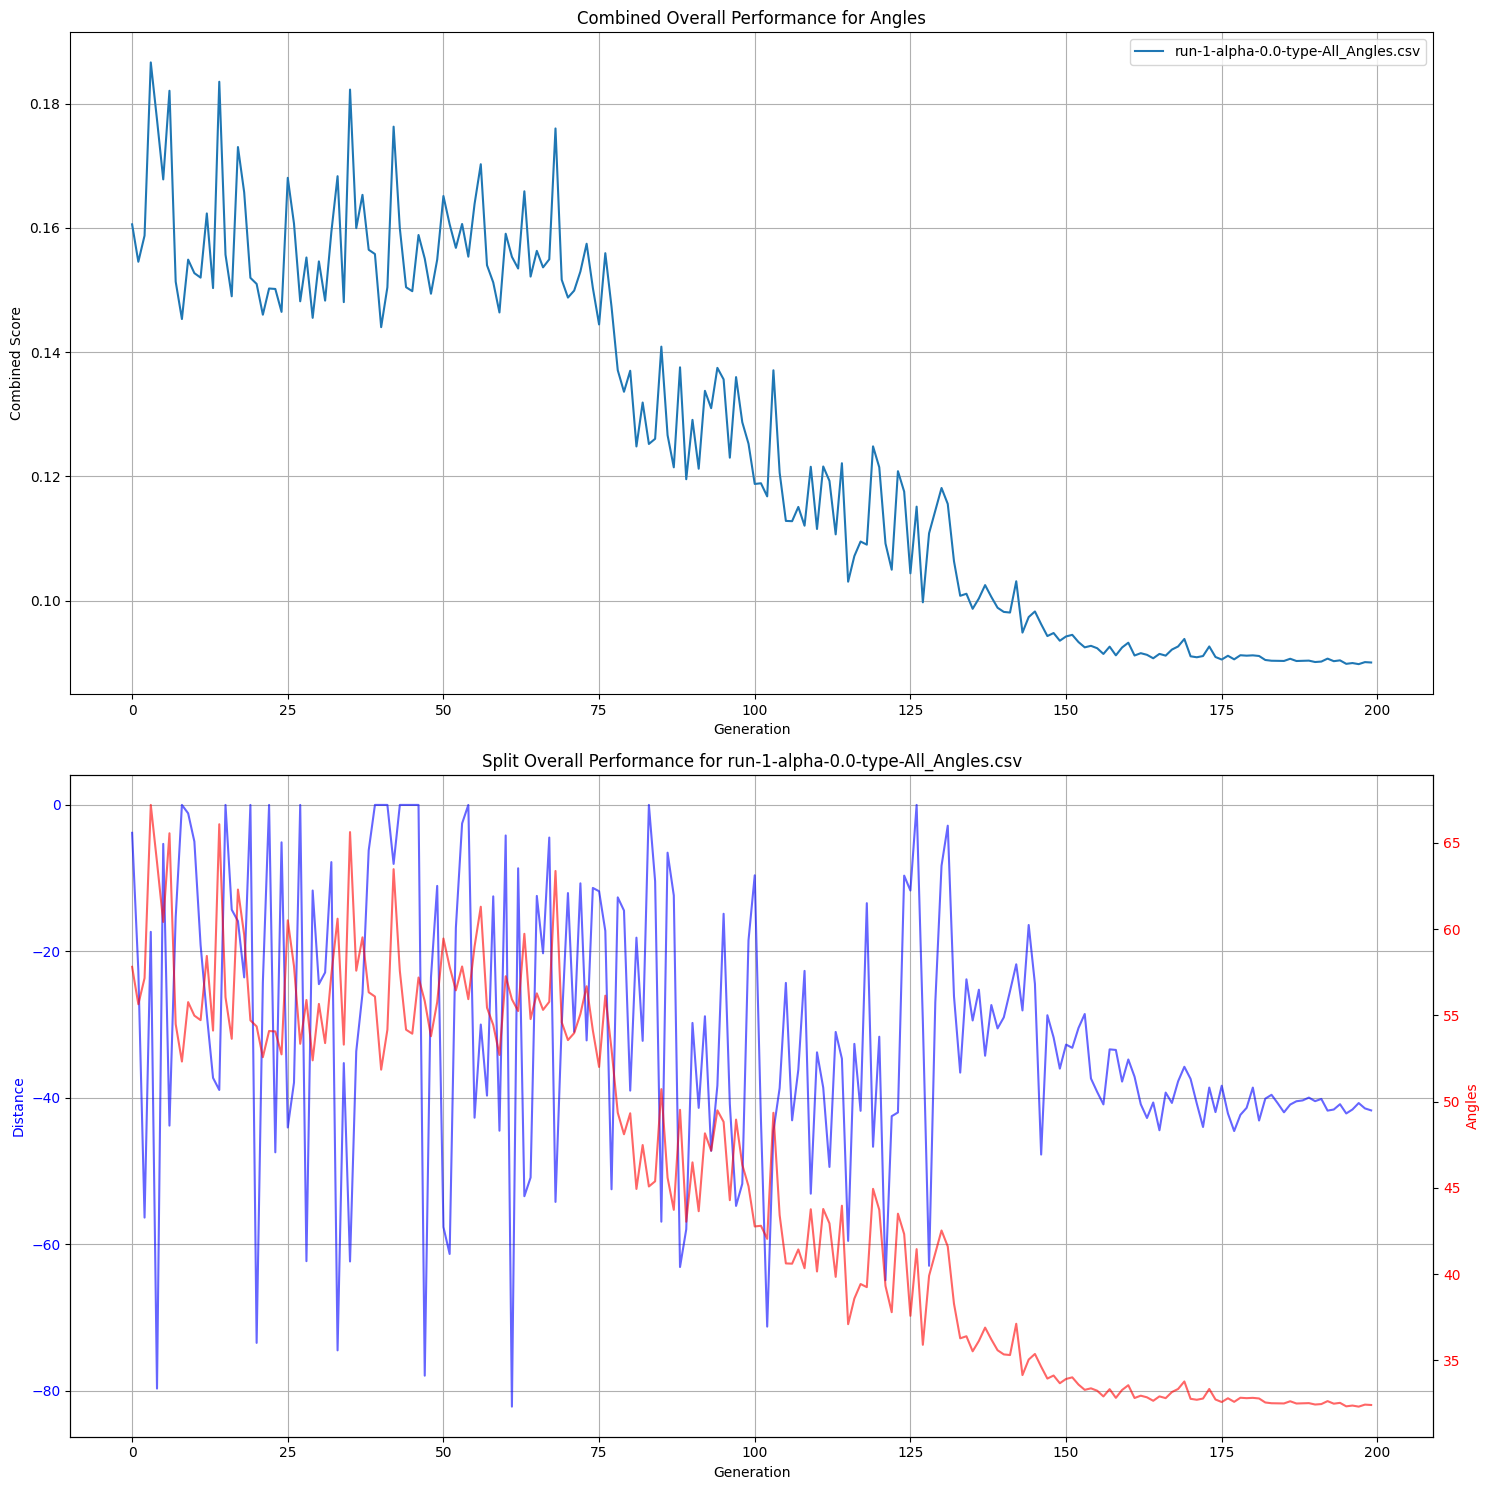

KeyboardInterrupt: 

In [13]:

def gen():
    name, dataset = plots[for_angles]

    # Before continuing, we need to generate the angle data for the animal dataset.
    # We do it here to save compute. Don't move it into the loop
    # Generate angle data for animal
    animal["angle1"] = animal.apply(lambda r:
                                    calculate_angle(
                                        r["right_front"],
                                        r["left_hind"],
                                        r["left_front"]
                                    ), axis=1)


    animal["angle2"] = animal.apply(lambda r:
                                    calculate_angle(
                                        r["left_front"],
                                        r["right_hind"],
                                        r["right_front"]
                                    ), axis=1)

    fix, ax = plt.subplots(1 + len(dataset), 1, figsize=(15,15))

    ax = ax.ravel()
    ax_i = 0


    ab_plot = ax[0]
    data_plot = ax[1]

    # Construct AB Plot
    ab_plot.set_title("Combined Overall Performance for Angles")
    ab_plot.set_xlabel("Generation")
    ab_plot.set_ylabel("Combined Score")
    
    for meta, df in dataset:
        ab_plot.plot(
            df['generation'],
            df['data_ab'].ewm(alpha=1).mean().values,
            label=meta.alpha_name, alpha=1)

    ab_plot.grid(visible=True, which="major")
    ab_plot.legend()

    # Construct Split Plots
    ax_i = 1
    for meta, df in dataset:
        ax[ax_i].set_title(f"Split Overall Performance for {meta.alpha_name}")
        ax[ax_i].set_xlabel("Generation")
        
        line_1 = ax[ax_i]
        line_2 = ax[ax_i].twinx()
        line_1.plot(
            df["generation"],
            df['data_distance'].ewm(alpha=1).mean().values,
            color='blue',
            label='<distance>' + meta.alpha_name, alpha=0.6)
        
        line_2.plot(
            df["generation"],
            df["data_angle"].ewm(alpha=1).mean().values,
            color='red',
            label='<angles>' + meta.alpha_name, alpha=0.6)

        ax[ax_i].grid(visible=True, which="major")

        # Add legends for both axes
        line_1.set_ylabel("Distance", color='blue')
        line_1.tick_params(axis='y', labelcolor='blue')

        line_2.set_ylabel("Angles", color='red')
        line_2.tick_params(axis='y', labelcolor='red')

        ax_i += 1

    plt.tight_layout()
    return plt

progressive_updates(gen)

### Generate Scores Over Time

In [ ]:

def gen():
    print("Plot Update")
    # Select only plots that have data to show
    to_plot = list(filter(lambda x: len(x[1]) > 0, plots))

    fig, ax = plt.subplots(len(to_plot),1,figsize=(20,14))

    for i, plot in enumerate(to_plot):
        plot_name = plot[0]
    
        # Crazy design choice, matplotlib.
        if len(to_plot) > 1: cur_ax = ax[i]
        else: cur_ax = ax
        
        for meta, df in plot[1]:
            cur_ax.plot(
                df["generation"], 
                df["data_ab"].ewm(alpha=1).mean().values,
                label=meta.alpha_name, alpha=1)

    
        cur_ax.set_xlabel("Generation")
        cur_ax.set_ylabel("Score")
        cur_ax.set_title(f"Fitness {plot_name} Performance Over Time")

        cur_ax.grid(visible=True, which="major")

        cur_ax.legend()

    fig.tight_layout()
    return plt

progressive_updates(gen)

### Generate Relative Angle Plots For Final Gen Over 5 Alphas

In [ ]:
from IPython.display import clear_output

def gen():
    select_plot = for_angles

    name, dataset = plots[select_plot]

    # Before continuing, we need to generate the angle data for the animal dataset.
    # We do it here to save compute. Don't move it into the loop
    # Generate angle data for animal
    animal["angle1"] = animal.apply(lambda r:
                                    calculate_angle(
                                        r["right_front"],
                                        r["left_hind"],
                                        r["left_front"]
                                    ), axis=1)


    animal["angle2"] = animal.apply(lambda r:
                                    calculate_angle(
                                        r["left_front"],
                                        r["right_hind"],
                                        r["right_front"]
                                    ), axis=1)

    fix, ax = plt.subplots(3, 2, figsize=(15,10))

    ax = ax.ravel()
    ax[5].axis('off') # We only have 5 plots, so we dont need a 6th rendered
    ax_i = 0

    for meta, df in dataset:
        target_gen = df['generation'].max()
        # Only compute angles for the target generation requested
        df_target = df.query(f"generation == {target_gen - 1}")

        angle1 = df_target.apply(lambda r: calculate_angle(
            r["right_front"], r["left_hind"], r["left_front"]), axis=1)

        # Required for how matplotlib plots
        _animal = animal.iloc[:len(df_target)]
        t_axis = np.arange(len(df_target))

        ax[ax_i].set_title(f"Generation {target_gen} Robot vs Animal Angle 1 Over Time ({meta.alpha_name})")
        ax[ax_i].plot(t_axis, angle1, label="Robot Angle 1 - RF LB LF")
        ax[ax_i].plot(t_axis, _animal["angle1"], label="Animal Angle 1 - RF LB LF")
        ax[ax_i].legend()

        ax_i += 1

    plt.tight_layout()
    return plt

progressive_updates(gen)

### Watch Angles Over Generations

In [ ]:
from IPython.display import clear_output

# KEY:
# 0 -> 0
# 0.25 -> 1
# 0.5 -> 2
# 0.75 -> 3
# 1 -> 4

def gen():
    select_plot = for_angles

    name, dataset = plots[select_plot]

    # Before continuing, we need to generate the angle data for the animal dataset.
    # We do it here to save compute. Don't move it into the loop
    # Generate angle data for animal
    animal["angle1"] = animal.apply(lambda r:
                                    calculate_angle(
                                        r["right_front"],
                                        r["left_hind"],
                                        r["left_front"]
                                    ), axis=1)


    animal["angle2"] = animal.apply(lambda r:
                                    calculate_angle(
                                        r["left_front"],
                                        r["right_hind"],
                                        r["right_front"]
                                    ), axis=1)

    fix, ax = plt.subplots(2, 1,figsize=(15,10))
    ax = ax.ravel()
    meta, df = dataset[2]

    target_gen = df['generation'].max()
    # target_gen = 100

    # Only compute angles for the target generation requested
    df_target = df.query(f"generation == {target_gen}")

    angle1 = df_target.apply(lambda r: calculate_angle(
        r["right_front"], r["left_hind"], r["left_front"]), axis=1)


    angle2 = df_target.apply(lambda r: calculate_angle(
        r["left_front"], r["right_hind"], r["right_front"]), axis=1)
    
    # Required for how matplotlib plots
    _animal = animal.iloc[:len(df_target)]
    t_axis = np.arange(len(df_target))


    ax[0].set_title(f"Generation {target_gen} Robot vs Animal Angle 1 Over Time ({meta.alpha_name})")
    ax[0].plot(t_axis, angle1, label="Robot Angle 1 - RF LB LF")
    ax[0].plot(t_axis, _animal["angle1"], label="Animal Angle 1 - RF LB LF")
    ax[0].legend()

    ax[1].set_title(f"Generation {target_gen} Robot vs Animal Angle 2 Over Time ({meta.alpha_name})")
    ax[1].plot(t_axis, angle2, label="Robot Angle 2 - LF RB RF")
    ax[1].plot(t_axis, _animal["angle2"], label="Animal Angle 2 - LF RB RF")
    ax[1].legend()


    plt.tight_layout()

progressive_updates(gen)

### Generate Permutation Plots For All Possible Angles Sourced From Animal CSV

In [ ]:
from itertools import permutations
import math

columns_to_permute =strings = ["left_front", "right_front", "head", "middle", "rear", "left_hind", "right_hind"]

permute_angles = list(permutations(columns_to_permute, 3))

# Select only top 20% that deviate
max_i = round(len(permute_angles) * 0.2)
x_total, y_total = divide_closely_square(max_i)

print(f"Plotting graph with ({y_total},{x_total}) plots")

computed_angles = []

for a1,a2,a3 in permute_angles:
    dataset = animal.iloc[:900].apply(
        lambda r: calculate_angle(r[a1], r[a2], r[a3]), axis=1)

    # The standard deviation is proportional to the amplitude of the sin wave. 
    # We store this alongside the angles to filter what type of charts we want.
    # To display.
    std = np.std(dataset)
    computed_angles.append((std, f"{a1}<>{a2}<>{a3}", dataset))
    print(f"Computing: {a1}<>{a2}<>{a3} :-> {std}")

computed_angles.sort(key=lambda x: x[0], reverse=True)

fig, ax = plt.subplots(y_total, x_total, figsize=(40, 15))
ax = ax.ravel()

for i in range(max_i):
    std, name, angle_data = computed_angles[i]

    t_axis = np.arange(len(angle_data))

    ax[i].set_title(f"{name}\nSTD: {std}")
    ax[i].plot(t_axis, angle_data)
    ax[i].grid(visible=True)

fig.tight_layout()
fig.show()